# Dependency Setup

In [2]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet

import random
from random import choice, randint

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

import re

import pickle

from sentence_transformers import SentenceTransformer, util

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config Definition

In [61]:
# file paths
ROOT = '/content/drive/MyDrive/CS5260 Project Group'
DATA_PATH = f'{ROOT}/data/preprocessed/raw_all.csv'
VOCAB_PATH = f'{ROOT}/baseline/vocab.pkl'
ADVERSARIAL_VOCAB_PATH = f'{ROOT}/baseline/adversarial_vocab.pkl'
EMBEDDING_MATRIX_PATH = f'{ROOT}/baseline/embedding_matrix.pth'
ADVERSARIAL_EMBEDDING_MATRIX_PATH = f'{ROOT}/baseline/adversarial_embedding_matrix.pth'
PRETRAINED_EMBEDDING_PATH = f'{ROOT}/baseline/GoogleNews-vectors-negative300.bin.gz'
LSTM_MODEL_PATH = f'{ROOT}/baseline/baseline_model.pth'
ADVERSARIAL_LSTM_MODEL_PATH = f'{ROOT}/baseline/baseline_adversarial_model.pth'
DATA_PATH_TRAIN = f'{ROOT}/baseline/data/train.csv'
DATA_PATH_VALIDATION = f'{ROOT}/baseline/data/val.csv'
DATA_PATH_TEST = f'{ROOT}/baseline/data/test.csv'
DATA_PATH_TEST_SPAMS = f'{ROOT}/baseline/data/test_spams.csv'
DATA_PATH_TEST_SPAMS_ATTACKED = f'{ROOT}/baseline/data/attacked_spam_emails'
DATA_PATH_TEST_SPAMS_ATTACKED_RESULT = f'{ROOT}/baseline/data/attacked_spam_emails_result'
DATA_PATH_ATTACK_PERFORMANCE_ACC = f'{ROOT}/baseline/data/attack_performance/accuracy.csv'
DATA_PATH_ATTACK_PERFORMANCE_SIM = f'{ROOT}/baseline/data/attack_performance/similarity.csv'
DATA_PATH_ADVERSARIAL_TRAINING= f'{ROOT}/baseline/data/adversarial_train.csv'
DATA_PATH_ADVERSARIAL_VALIDATION = f'{ROOT}/baseline/data/adversarial_val.csv'
DATA_PATH_ADVERSARIAL_TEST = f'{ROOT}/baseline/data/adversarial_test.csv'
DATA_PATH_ADVERSARIAL_SPAMS = f'{ROOT}/baseline/data/adversarial_spams.csv'
DATA_PATH_TEST_SPAMS_ATTACKED_ADVERSARIAL_RESULT = f'{ROOT}/baseline/data/attacked_spam_emails_adversarial_result'
DATA_PATH_DEFEND_PERFORMANCE_ACC = f'{ROOT}/baseline/data/defend_performance/accuracy.csv'
DATA_PATH_DEFEND_PERFORMANCE_SIM = f'{ROOT}/baseline/data/defend_performance/similarity.csv'

# dataloader
BATCH_SIZE = 16
BATCH_SIZE_ADVERSARIAL = 8
NUM_WORKERS = 4

# model
EMBED_DIM = 300
HIDDEN_DIM = 128
OUT_DIM = 2
N_LAYERS = 2
DROPOUT = 0.2

# training
N_EPOCHS = 20
N_EPOCHS_ADVERSARIAL = 10
LR_START = 0.001
LR_SCHEDULER_FACTOR = 0.2
LR_SCHEDULER_PATIENCE = int(N_EPOCHS / 5)
LR_SCHEDULER_PATIENCE_ADVERSARIAL = int(N_EPOCHS_ADVERSARIAL / 5)
L2_REG_WEIGHT_DECAY = 1e-5

# attack
ATTACK_RATES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
AUGMENT_RATE = 0.5

# Build Model

## Util Functions, Dataset & Model Definition

In [6]:
def build_dfs(all_csv_path):
    df_all = pd.read_csv(all_csv_path)
    df_all.rename(columns={'spam': 'label'}, inplace=True)

    df_train_val, df_test = train_test_split(df_all, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    return df_train, df_val, df_test

def build_tokenizer():
    return get_tokenizer("basic_english")

def build_vocab(tokenizer, df):
    vocab = build_vocab_from_iterator(map(tokenizer, df["original_text"]), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    return vocab

def save_vocab(vocab, vocab_path):
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

def load_vocab(vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    return vocab

def load_pretrained_embedding(pretrained_path):
    pretrained = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)
    return pretrained

def build_embedding_matrix(vocab, embed_dim, pretrained):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    for word, idx in vocab.get_stoi().items():
        if word in pretrained:
            embedding_matrix[idx] = pretrained[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

def save_embedding_matrix(embedding_matrix, embedding_matrix_path):
    torch.save(embedding_matrix, embedding_matrix_path)

def load_embedding_matrix(embedding_matrix_path):
    return torch.load(embedding_matrix_path)

def batch_collate(batch):
    text, label = zip(*batch)
    text = pad_sequence(text, batch_first=True)
    label = torch.stack(label)
    return text, label

def train(model, data_loader, optimizer, criterion, device):
    model.train()
    model.to(device)
    epoch_loss = 0
    for text, label in data_loader:
        text, label = text.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def eval(model, data_loader, criterion, device):
    model.eval()
    model.to(device)
    epoch_loss = 0
    original_labels = []
    predicted_labels = []
    with torch.no_grad():
        for text, label in data_loader:
            text, label = text.to(device), label.to(device)
            output = model(text)
            loss = criterion(output, label)
            epoch_loss += loss.item()
            predicted_labels.append(output.argmax(dim=1))
            original_labels.append(label)
    correct = (torch.cat(predicted_labels) == torch.cat(original_labels)).sum().item()
    total = len(torch.cat(original_labels))
    accuracy = correct / total
    return epoch_loss / len(data_loader), accuracy

def start_training(model, dl_train, dl_val, optimizer, criterion, lr_scheduler, n_epochs, device, save_path):
    loss_train = []
    loss_val = []
    acc_val = []
    best_acc_val = 0
    for epoch in range(n_epochs):
        train_loss = train(model, dl_train, optimizer, criterion, device)
        val_loss, val_acc = eval(model, dl_val, criterion, device)
        loss_train.append(train_loss)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        lr_scheduler.step(val_loss)
        print(f'Epoch {epoch + 1} - train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}')

        if val_acc > best_acc_val:
            best_acc_val = val_acc
            torch.save(model.state_dict(), save_path)
    return loss_train, loss_val, acc_val

def load_model_from_path(model_path, embedding_matrix_path):
    saved_embedding_matrix = load_embedding_matrix(embedding_matrix_path)
    saved_model = SpamLSTM(saved_embedding_matrix, EMBED_DIM, HIDDEN_DIM, OUT_DIM, N_LAYERS, DROPOUT)
    saved_model.load_state_dict(torch.load(model_path))
    return saved_model

class SpamDataset(Dataset):
    def __init__(self, data, tokenizer, vocab, transform=None):
        self.length = len(data)
        self.texts = data['original_text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        if self.transform is not None:
            text = self.transform(text)
        label = self.labels.iloc[idx]
        tokens = self.vocab(self.tokenizer(text))
        return torch.tensor(tokens), torch.tensor(label)

class SpamLSTM(nn.Module):
    def __init__(self, embedding_matrix, embed_dim, hidden_dim, out_dim, n_layers, dropout):
        super(SpamLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc(hidden)
        out = self.dropout(out)
        return out

## Dataset Preparation
Divide original dataset to 60% training, 20% validation and 20% test.



In [ ]:
df_train, df_val, df_test = build_dfs(DATA_PATH)
df_test_spams = df_test[df_test['label'] == 1]

df_train.to_csv(DATA_PATH_TRAIN, index=False)
df_val.to_csv(DATA_PATH_VALIDATION, index=False)
df_test.to_csv(DATA_PATH_TEST, index=False)
df_test_spams.to_csv(DATA_PATH_TEST_SPAMS, index=False)

In [ ]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_val = pd.read_csv(DATA_PATH_VALIDATION)
df_test = pd.read_csv(DATA_PATH_TEST)
df_test_spams = pd.read_csv(DATA_PATH_TEST_SPAMS)
print(f'Dataset Metrics:')
print(f"Training: Spam - {len(df_train[df_train['label'] == 1])}, Non Spam - {len(df_train[df_train['label'] == 0])}, Total - {len(df_train)}")
print(f"Validation: Spam - {len(df_val[df_val['label'] == 1])}, Non Spam - {len(df_val[df_val['label'] == 0])}, Total - {len(df_val)}")
print(f"Test: Spam - {len(df_test[df_test['label'] == 1])}, Non Spam - {len(df_test[df_test['label'] == 0])}, Total - {len(df_test)}")
print(f"Test Spams: Spam - {len(df_test_spams[df_test_spams['label'] == 1])}, Non Spam - {len(df_test_spams[df_test_spams['label'] == 0])}, Total - {len(df_test_spams)}")

Dataset Metrics:
Training: Spam - 9448, Non Spam - 12672, Total - 22120
Validation: Spam - 3126, Non Spam - 4248, Total - 7374
Test: Spam - 3140, Non Spam - 4234, Total - 7374
Test Spams: Spam - 3140, Non Spam - 0, Total - 3140


## Tokenizer and Vocabulary

In [ ]:
tokenizer = build_tokenizer()
vocab = build_vocab(tokenizer, df_train)
save_vocab(vocab, VOCAB_PATH)

## Embedding Matrix (Pretrained Word2Vec)

In [ ]:
pretrained = load_pretrained_embedding(PRETRAINED_EMBEDDING_PATH)
embedding_matrix = build_embedding_matrix(vocab, EMBED_DIM, pretrained)
save_embedding_matrix(embedding_matrix, EMBEDDING_MATRIX_PATH)

## Pre-Training - Dataloader

In [ ]:
tokenizer = build_tokenizer()
vocab = load_vocab(VOCAB_PATH)

ds_train = SpamDataset(df_train, tokenizer, vocab)
ds_val = SpamDataset(df_val, tokenizer, vocab)
ds_test = SpamDataset(df_test, tokenizer, vocab)
ds_test_spams = SpamDataset(df_test_spams, tokenizer, vocab)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_test_spams = DataLoader(ds_test_spams, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)

## Pre-Training - Model

In [ ]:
embedding_matrix = load_embedding_matrix(EMBEDDING_MATRIX_PATH)
model = SpamLSTM(embedding_matrix, EMBED_DIM, HIDDEN_DIM, OUT_DIM, N_LAYERS, DROPOUT)

## Pre-Training - Optimizer, LR Scheduler and Loss Criterion

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=LR_START, weight_decay=L2_REG_WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Start Training

In [ ]:
loss_train, loss_val, acc_val = start_training(model, dl_train, dl_val, optimizer, criterion, lr_scheduler, N_EPOCHS, device, LSTM_MODEL_PATH)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 - train loss: 0.3227, val loss: 0.1590, val accuracy: 0.9426
Epoch 2 - train loss: 0.1874, val loss: 0.2351, val accuracy: 0.9143
Epoch 3 - train loss: 0.1399, val loss: 0.0864, val accuracy: 0.9672
Epoch 4 - train loss: 0.1216, val loss: 0.0847, val accuracy: 0.9704
Epoch 5 - train loss: 0.0939, val loss: 0.0617, val accuracy: 0.9790
Epoch 6 - train loss: 0.0697, val loss: 0.0684, val accuracy: 0.9772
Epoch 7 - train loss: 0.0624, val loss: 0.0741, val accuracy: 0.9784
Epoch 8 - train loss: 0.0555, val loss: 0.0819, val accuracy: 0.9760
Epoch 9 - train loss: 0.0529, val loss: 0.0587, val accuracy: 0.9811
Epoch 10 - train loss: 0.0461, val loss: 0.0614, val accuracy: 0.9826
Epoch 11 - train loss: 0.0439, val loss: 0.0656, val accuracy: 0.9839
Epoch 12 - train loss: 0.0444, val loss: 0.0669, val accuracy: 0.9788
Epoch 13 - train loss: 0.0405, val loss: 0.0693, val accuracy: 0.9841
Epoch 14 - train loss: 0.0433, val loss: 0.0657, val accuracy: 0.9790
Epoch 15 - train loss: 0.0325

## Performance Evaluation

In [ ]:
model = load_model_from_path(LSTM_MODEL_PATH, EMBEDDING_MATRIX_PATH)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_avg_loss, test_acc = eval(model, dl_test, criterion, device)
print(f'test loss: {test_avg_loss:.4f}, test accuracy - {test_acc:.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


test loss: 0.0926, test accuracy - 0.9837


In [ ]:
test_spams_avg_loss, test_spams_acc = eval(model, dl_test_spams, criterion, device)
print(f'test spams loss: {test_spams_avg_loss:.4f}, test spams accuracy - {test_spams_acc:.4f}')

test spams loss: 0.1351, test spams accuracy - 0.9745


# Adversarial Attack with Text Perturbation

## Attacker Definition
Define adversarial attacker with 5 types of adversarial attack:
*   synonyms replacement on word level (multi-word synonyms allowed)
*   homoglyph replacement on character level
*   keyboard typo replacement on character level
*   special character insertion on character level
*   shuffling on sentence level

In [42]:
class Attacker:
    def __init__(self):
        self.attack_types = ['synonym', 'homoglyph', 'keyboard_typo', 'special_char_insertion']
        self.ATTACK_TYPE_SYN = 'synonym'
        self.ATTACK_TYPE_HOM = 'homoglyph'
        self.ATTACK_TYPE_KEY = 'keyboard_typo'
        self.ATTACK_TYPE_SPE = 'special_char_insertion'
        self.ATTACK_TYPE_RAN = 'random'
        nltk.download('punkt')
        nltk.download('wordnet')

    def attack(self, text, attack_rate, sentence_shuffling=False, attack_type='random'):
        text_to_attack = text
        if sentence_shuffling:
            text_to_attack = self.shuffle_sentence(text_to_attack)
        words = text_to_attack.split()
        perturbed_text = []
        for word in words:
            if randint(0, 100) < attack_rate * 100:
                perturbed_text.append(self.attack_token(word, attack_type))
            else:
                perturbed_text.append(word)
        return ' '.join(perturbed_text)

    def shuffle_sentence(self, text):
        sentences = sent_tokenize(text)
        random.shuffle(sentences)
        shuffled = ' '.join(sentences)
        return shuffled

    def attack_token(self, token, attack_type):
        if attack_type == self.ATTACK_TYPE_SYN:
            replacement = self.replace_with_synonyms(token)
        elif attack_type == self.ATTACK_TYPE_HOM:
            replacement = self.replace_with_homoglyphs(token)
        elif attack_type == self.ATTACK_TYPE_KEY:
            replacement = self.replace_with_keyboard_typo(token)
        elif attack_type == self.ATTACK_TYPE_SPE:
            replacement = self.replace_with_special_char_insertion(token)
        elif attack_type == self.ATTACK_TYPE_RAN:
            random_attack_type = choice(self.attack_types)
            replacement = self.attack_token(token, random_attack_type)
        else:
            replacement = token
        return replacement

    def replace_with_synonyms(self, word):
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                synonyms.add(synonym)
        if len(synonyms) == 0:
            synonyms.add(word)
        synonym_list = list(synonyms)
        return choice(synonym_list)

    def replace_with_homoglyphs(self, word):
        homoglyphs = {
            'o': ['0', 'ӧ', 'ö', 'ò', 'ó', 'ô', 'õ', 'ø', 'ō', 'ŏ', 'ő'],
            'a': ['а', '@', 'ä', 'à', 'á', 'â', 'ã', 'å', 'ā', 'ă', 'ą', 'α', 'а'],
            'e': ['е', '3', 'ë', 'è', 'é', 'ê', 'ē', 'ĕ', 'ė', 'ę', 'ě', 'ε', 'ё'],
            'i': ['1', 'l', 'í', 'ì', 'ï', 'î', 'ī', 'ĩ', 'ĭ', 'ı', 'ι', 'і', 'ї'],
            's': ['$', '5', 'ś', 'š', 'ș', 'с', 'ς'],
            'g': ['q', '9', 'ğ', 'ģ', 'ĝ', 'γ', 'г', 'ґ'],
            'b': ['6', 'ß', 'β', 'Ь', 'Ъ', 'ъ', 'ь', 'ƅ'],
            'c': ['с', 'ć', 'č', 'ĉ', 'ċ'],
            'l': ['1', 'i', 'ł', 'ľ', 'ĺ', 'ļ', 'λ', 'л'],
            'd': ['ð', 'ď', 'đ', 'ԁ', 'Ԁ', 'δ', 'д'],
            't': ['τ', 'т', 'ť', 'ţ'],
            'h': ['н', 'ĥ', 'ħ', 'η'],
            'm': ['м', 'ɱ'],
            'n': ['ñ', 'ń', 'ņ', 'ň', 'ŉ', 'η', 'п'],
            'p': ['ρ', 'р', 'þ', 'φ'],
            'r': ['г', 'ř', 'ŗ', 'ŕ'],
            'u': ['ù', 'ú', 'û', 'ü', 'ū', 'ŭ', 'ů', 'ű', 'ų', 'µ', 'υ', 'ц'],
            'v': ['ν', 'ѵ', 'ѷ'],
            'w': ['ω', 'ш', 'ѡ', 'ѿ'],
            'x': ['×', 'х', 'ж'],
            'y': ['ý', 'ÿ', 'ŷ', 'у'],
            'z': ['ź', 'ż', 'ž', 'ζ', 'з', 'ʐ', 'ʑ'],
        }
        homoglyphs_complexity = randint(1, len(word))
        homoglyphs_count = 0
        new_text = ""
        for char in word:
            if char in homoglyphs:
                if homoglyphs_count >= homoglyphs_complexity:
                    new_text += char
                    continue
                else:
                    new_text += choice(homoglyphs[char])
                    homoglyphs_count += 1
            else:
                    new_text += char
        return new_text

    def replace_with_keyboard_typo(self, word):
        typo_map = {
            'q': ['w', 'a'],
            'w': ['q', 'e', 'a', 's'],
            'e': ['w', 'r', 's', 'd'],
            'r': ['e', 't', 'd', 'f'],
            't': ['r', 'y', 'f', 'g'],
            'y': ['t', 'u', 'g', 'h'],
            'u': ['y', 'i', 'h', 'j'],
            'i': ['u', 'o', 'j', 'k'],
            'o': ['i', 'p', 'k', 'l'],
            'p': ['o', 'l'],
            'a': ['q', 'w', 's', 'z'],
            's': ['w', 'e', 'a', 'd', 'z', 'x'],
            'd': ['e', 'r', 's', 'f', 'x', 'c'],
            'f': ['r', 't', 'd', 'g', 'c', 'v'],
            'g': ['t', 'y', 'f', 'h', 'v', 'b'],
            'h': ['y', 'u', 'g', 'j', 'b', 'n'],
            'j': ['u', 'i', 'h', 'k', 'n', 'm'],
            'k': ['i', 'o', 'j', 'l', 'm'],
            'l': ['o', 'p', 'k'],
            'z': ['a', 's', 'x'],
            'x': ['s', 'd', 'z', 'c'],
            'c': ['d', 'f', 'x', 'v'],
            'v': ['f', 'g', 'c', 'b'],
            'b': ['g', 'h', 'v', 'n'],
            'n': ['h', 'j', 'b', 'm'],
            'm': ['j', 'k', 'n'],
        }
        typo_type = ['insert', 'delete', 'swap', 'substitute']
        typo_pos = randint(0, len(word) - 1)
        random_typo_chosen = choice(typo_type)
        if random_typo_chosen == 'insert':
            if word[typo_pos].lower() in typo_map:
                char_to_insert = choice(typo_map[word[typo_pos].lower()] + [word[typo_pos].lower()])
                return word[:typo_pos] + char_to_insert + word[typo_pos:]
            else:
                return word

        elif random_typo_chosen == 'delete':
            return word[:typo_pos] + word[typo_pos + 1:]

        elif random_typo_chosen == 'swap':
            if typo_pos == len(word) - 1:
                return word[:typo_pos - 1] + word[typo_pos] + word[typo_pos - 1]
            else:
                return word[:typo_pos] + word[typo_pos + 1] + word[typo_pos] + word[typo_pos + 1:]

        else:
            if word[typo_pos].lower() in typo_map:
                char_to_substitute = choice(typo_map[word[typo_pos].lower()])
                return word[:typo_pos] + char_to_substitute + word[typo_pos + 1:]
            else:
                return word

    def replace_with_special_char_insertion(self, word):
        insertion_rate = randint(1, 5) / 10
        special_chars = ['&', '\\', '}', '$', '•', '£', '¥', '-', '^', ']',
                         ';', '|', '"', '€', '[', '?', '_', ',', '%', '{',
                         '+', '…', ':', '*', '(', "'", '!', '`', '~', '–',
                         '<', ')', '@', '/', '>', '¢', '=', '#', '.', ' ']
        perturbed_word = ""
        for char in word:
            perturbed_word += char
            if randint(0, 100) < insertion_rate * 100:
                perturbed_word += choice(special_chars)
        return perturbed_word

    def build_attacked_dataset(self, df_original_spams, path):
        for rate in ATTACK_RATES:
            df_syn_shuffled = self.copy_attack_dfs(df_original_spams)
            df_syn_unshuffled = self.copy_attack_dfs(df_original_spams)
            df_hom_shuffled = self.copy_attack_dfs(df_original_spams)
            df_hom_unshuffled = self.copy_attack_dfs(df_original_spams)
            df_key_shuffled = self.copy_attack_dfs(df_original_spams)
            df_key_unshuffled = self.copy_attack_dfs(df_original_spams)
            df_spe_shuffled = self.copy_attack_dfs(df_original_spams)
            df_spe_unshuffled = self.copy_attack_dfs(df_original_spams)
            df_ran_shuffled = self.copy_attack_dfs(df_original_spams)
            df_ran_unshuffled = self.copy_attack_dfs(df_original_spams)


            df_syn_shuffled['attacked_text'] = df_syn_shuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=True, attack_type=self.ATTACK_TYPE_SYN))
            df_syn_unshuffled['attacked_text'] = df_syn_unshuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=False, attack_type=self.ATTACK_TYPE_SYN))

            df_hom_shuffled['attacked_text'] = df_hom_shuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=True, attack_type=self.ATTACK_TYPE_HOM))
            df_hom_unshuffled['attacked_text'] = df_hom_unshuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=False, attack_type=self.ATTACK_TYPE_HOM))

            df_key_shuffled['attacked_text'] = df_key_shuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=True, attack_type=self.ATTACK_TYPE_KEY))
            df_key_unshuffled['attacked_text'] = df_key_unshuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=False, attack_type=self.ATTACK_TYPE_KEY))

            df_spe_shuffled['attacked_text'] = df_spe_shuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=True, attack_type=self.ATTACK_TYPE_SPE))
            df_spe_unshuffled['attacked_text'] = df_spe_unshuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=False, attack_type=self.ATTACK_TYPE_SPE))

            df_ran_shuffled['attacked_text'] = df_ran_shuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=True, attack_type=self.ATTACK_TYPE_RAN))
            df_ran_unshuffled['attacked_text'] = df_ran_unshuffled['original_text'].apply(lambda text:self.attack(text, rate, sentence_shuffling=False, attack_type=self.ATTACK_TYPE_RAN))

            df_syn_shuffled.to_csv(f'{path}/syn_shuffled_{rate}.csv', index=False)
            df_syn_unshuffled.to_csv(f'{path}/syn_unshuffled_{rate}.csv', index=False)
            df_hom_shuffled.to_csv(f'{path}/hom_shuffled_{rate}.csv', index=False)
            df_hom_unshuffled.to_csv(f'{path}/hom_unshuffled_{rate}.csv', index=False)
            df_key_shuffled.to_csv(f'{path}/key_shuffled_{rate}.csv', index=False)
            df_key_unshuffled.to_csv(f'{path}/key_unshuffled_{rate}.csv', index=False)
            df_spe_shuffled.to_csv(f'{path}/spe_shuffled_{rate}.csv', index=False)
            df_spe_unshuffled.to_csv(f'{path}/spe_unshuffled_{rate}.csv', index=False)
            df_ran_shuffled.to_csv(f'{path}/ran_shuffled_{rate}.csv', index=False)
            df_ran_unshuffled.to_csv(f'{path}/ran_unshuffled_{rate}.csv', index=False)

    def copy_attack_dfs(self, df_original_spams):
        df = pd.DataFrame(columns=['original_text', 'attacked_text', 'source'])
        df['original_text'] = df_original_spams['original_text'].copy()
        df['attacked_text'] = df_original_spams['original_text'].copy()
        df['source'] = df_original_spams['source'].copy()
        return df


## Build Attacked Datasets

In [ ]:
attacker = Attacker()
attacker.build_attacked_dataset(df_test_spams, DATA_PATH_TEST_SPAMS_ATTACKED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


This is an attacker example. Please attack this message. Tĥānk you :
This is an attacker example. Please attack this message. hThank you :)
This іs an assailant example. Please attack this; message. Thank you :)
Thuis is ąn attacker example. please attack tbis message. Thank you :)
This is an attacker example. Please onset this message. Thank ÿӧų :)


## Util Functions Definition

In [69]:
class AttackDataset(Dataset):
    def __init__(self, data, tokenizer, vocab, transform=None):
        self.length = len(data)
        self.texts = data['attacked_text']
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        if self.transform is not None:
            text = self.transform(text)
        tokens = self.vocab(self.tokenizer(text))
        return torch.tensor(tokens), torch.tensor(1)

class USEPyTorch:
    def __init__(self, model_name):
        # Initialize the model from the sentence-transformers library
        self.model = SentenceTransformer(model_name)

    def semantic_sim(self, sents1, sents2):
        # Convert sentences to lower case and get embeddings
        embeddings1 = self.model.encode([s.lower() for s in sents1], convert_to_tensor=True)
        embeddings2 = self.model.encode([s.lower() for s in sents2], convert_to_tensor=True)

        # Compute cosine similarities
        cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2)
        return cosine_similarities

def run_attack_experiments(model, vocab, tokenizer, attack_data_path, attack_result_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for rate in ATTACK_RATES:
        df_syn_shuffled = pd.read_csv(f'{attack_data_path}/syn_shuffled_{rate}.csv')
        df_syn_unshuffled = pd.read_csv(f'{attack_data_path}/syn_unshuffled_{rate}.csv')
        df_hom_shuffled = pd.read_csv(f'{attack_data_path}/hom_shuffled_{rate}.csv')
        df_hom_unshuffled = pd.read_csv(f'{attack_data_path}/hom_unshuffled_{rate}.csv')
        df_key_shuffled = pd.read_csv(f'{attack_data_path}/key_shuffled_{rate}.csv')
        df_key_unshuffled = pd.read_csv(f'{attack_data_path}/key_unshuffled_{rate}.csv')
        df_spe_shuffled = pd.read_csv(f'{attack_data_path}/spe_shuffled_{rate}.csv')
        df_spe_unshuffled = pd.read_csv(f'{attack_data_path}/spe_unshuffled_{rate}.csv')
        df_ran_shuffled = pd.read_csv(f'{attack_data_path}/ran_shuffled_{rate}.csv')
        df_ran_unshuffled = pd.read_csv(f'{attack_data_path}/ran_unshuffled_{rate}.csv')

        df_syn_shuffled['classified_as'] = df_syn_shuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_syn_unshuffled['classified_as'] = df_syn_unshuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_hom_shuffled['classified_as'] = df_hom_shuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_hom_unshuffled['classified_as'] = df_hom_unshuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_key_shuffled['classified_as'] = df_key_shuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_key_unshuffled['classified_as'] = df_key_unshuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_spe_shuffled['classified_as'] = df_spe_shuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_spe_unshuffled['classified_as'] = df_spe_unshuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_ran_shuffled['classified_as'] = df_ran_shuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))
        df_ran_unshuffled['classified_as'] = df_ran_unshuffled['attacked_text'].apply(lambda text:classify_attacked_text(model, text, vocab, tokenizer, device))

        df_syn_shuffled.to_csv(f'{attack_result_path}/result_syn_shuffled_{rate}.csv', index=False)
        df_syn_unshuffled.to_csv(f'{attack_result_path}/result_syn_unshuffled_{rate}.csv', index=False)
        df_hom_shuffled.to_csv(f'{attack_result_path}/result_hom_shuffled_{rate}.csv', index=False)
        df_hom_unshuffled.to_csv(f'{attack_result_path}/result_hom_unshuffled_{rate}.csv', index=False)
        df_key_shuffled.to_csv(f'{attack_result_path}/result_key_shuffled_{rate}.csv', index=False)
        df_key_unshuffled.to_csv(f'{attack_result_path}/result_key_unshuffled_{rate}.csv', index=False)
        df_spe_shuffled.to_csv(f'{attack_result_path}/result_spe_shuffled_{rate}.csv', index=False)
        df_spe_unshuffled.to_csv(f'{attack_result_path}/result_spe_unshuffled_{rate}.csv', index=False)
        df_ran_shuffled.to_csv(f'{attack_result_path}/result_ran_shuffled_{rate}.csv', index=False)
        df_ran_unshuffled.to_csv(f'{attack_result_path}/result_ran_unshuffled_{rate}.csv', index=False)

        print(f'Experiment for attack rate {rate} is completed. Result saved to {attack_result_path}.')

def read_attack_df_to_dataloader(df_path, tokenizer, vocab):
    df = pd.read_csv(df_path)
    ds = AttackDataset(df, tokenizer, vocab)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)
    return dl

def classify_attacked_text(model, attacked_text, vocab, tokenizer, device):
    text_tensor = convert_text_to_tensor(attacked_text, vocab, tokenizer)
    text_tensor = text_tensor.to(device)
    model.eval()
    model.to(device)
    output = model(text_tensor)
    predicted_label = output.argmax(dim=1)
    return int(predicted_label)

def convert_text_to_tensor(text, vocab, tokenizer):
    text_tensor = torch.tensor(vocab(tokenizer(text))).unsqueeze(0)
    return text_tensor

def eval_experiments_result(attack_result_path, acc_performance_path, sim_performance_path):
    result_accuracy = pd.DataFrame(columns=['Attack Rate',
                                   'Synonyms Replacement (Shuffled)',
                                   'Synonyms Replacement (Unshuffled)',
                                   'Homoglyphs Replacement (Shuffled)',
                                   'Homoglyphs Replacement (Unshuffled)',
                                   'Keyboard Typo Simulation (Shuffled)',
                                   'Keyboard Typo Simulation (Unshuffled)',
                                   'Special Character Insertion (Shuffled)',
                                   'Special Character Insertion (Unshuffled)',
                                   'Random (Shuffled)',
                                   'Random (Unshuffled)'
                                   ])
    result_similarity = pd.DataFrame(columns=['Attack Rate',
                                   'Synonyms Replacement (Shuffled)',
                                   'Synonyms Replacement (Unshuffled)',
                                   'Homoglyphs Replacement (Shuffled)',
                                   'Homoglyphs Replacement (Unshuffled)',
                                   'Keyboard Typo Simulation (Shuffled)',
                                   'Keyboard Typo Simulation (Unshuffled)',
                                   'Special Character Insertion (Shuffled)',
                                   'Special Character Insertion (Unshuffled)',
                                   'Random (Shuffled)',
                                   'Random (Unshuffled)'
                                   ])
    accuracy_series = []
    similarity_series = []
    for rate in ATTACK_RATES:
        df_result_syn_shuffled = pd.read_csv(f'{attack_result_path}/result_syn_shuffled_{rate}.csv')
        df_result_syn_unshuffled = pd.read_csv(f'{attack_result_path}/result_syn_unshuffled_{rate}.csv')
        df_result_hom_shuffled = pd.read_csv(f'{attack_result_path}/result_hom_shuffled_{rate}.csv')
        df_result_hom_unshuffled = pd.read_csv(f'{attack_result_path}/result_hom_unshuffled_{rate}.csv')
        df_result_key_shuffled = pd.read_csv(f'{attack_result_path}/result_key_shuffled_{rate}.csv')
        df_result_key_unshuffled = pd.read_csv(f'{attack_result_path}/result_key_unshuffled_{rate}.csv')
        df_result_spe_shuffled = pd.read_csv(f'{attack_result_path}/result_spe_shuffled_{rate}.csv')
        df_result_spe_unshuffled = pd.read_csv(f'{attack_result_path}/result_spe_unshuffled_{rate}.csv')
        df_result_ran_shuffled = pd.read_csv(f'{attack_result_path}/result_ran_shuffled_{rate}.csv')
        df_result_ran_unshuffled = pd.read_csv(f'{attack_result_path}/result_ran_unshuffled_{rate}.csv')

        accuracy_series.append(pd.Series([rate,
                                          calculate_model_accuracy_after_attack(df_result_syn_shuffled),
                                          calculate_model_accuracy_after_attack(df_result_syn_unshuffled),
                                          calculate_model_accuracy_after_attack(df_result_hom_shuffled),
                                          calculate_model_accuracy_after_attack(df_result_hom_unshuffled),
                                          calculate_model_accuracy_after_attack(df_result_key_shuffled),
                                          calculate_model_accuracy_after_attack(df_result_key_unshuffled),
                                          calculate_model_accuracy_after_attack(df_result_spe_shuffled),
                                          calculate_model_accuracy_after_attack(df_result_spe_unshuffled),
                                          calculate_model_accuracy_after_attack(df_result_ran_shuffled),
                                          calculate_model_accuracy_after_attack(df_result_ran_unshuffled)],
                                         index=result_accuracy.columns))
        similarity_series.append(pd.Series([rate,
                                          calculate_text_similarity_for_successful_attacks(df_result_syn_shuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_syn_unshuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_hom_shuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_hom_unshuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_key_shuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_key_unshuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_spe_shuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_spe_unshuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_ran_shuffled),
                                          calculate_text_similarity_for_successful_attacks(df_result_ran_unshuffled)],
                                         index=result_accuracy.columns))

        print(f'Evaluation completed for attack rate {rate}.')

    result_accuracy = pd.concat([result_accuracy, pd.DataFrame(accuracy_series)], axis=0, ignore_index=True)
    result_similarity = pd.concat([result_similarity, pd.DataFrame(similarity_series)], axis=0, ignore_index=True)
    result_accuracy.to_csv(acc_performance_path, index=False)
    result_similarity.to_csv(sim_performance_path, index=False)

def calculate_model_accuracy_after_attack(df_result):
    correct = len(df_result[df_result['classified_as'] == 1])
    total = len(df_result)
    return correct / total

def calculate_text_similarity_for_successful_attacks(df_result):
    model_name = 'all-MiniLM-L6-v2'  # A compact model from sentence-transformers
    use_model_pytorch = USEPyTorch(model_name)

    df_successful_attack = df_result[df_result['classified_as'] == 0]
    sim_scores = []
    for idx, row in df_successful_attack.iterrows():
        sim_score = use_model_pytorch.semantic_sim([row['original_text']], [row['attacked_text']]).item()
        sim_scores.append(sim_score)
    return sum(sim_scores) / len(sim_scores)


## Run Attack Experiments

In [ ]:
tokenizer = build_tokenizer()
vocab = load_vocab(VOCAB_PATH)
model = load_model_from_path(LSTM_MODEL_PATH, EMBEDDING_MATRIX_PATH)
run_attack_experiments(model, vocab, tokenizer, DATA_PATH_TEST_SPAMS_ATTACKED, DATA_PATH_TEST_SPAMS_ATTACKED_RESULT)

Experiment for attack rate 0.1 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.2 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.3 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.4 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.5 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.6 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_result.
Experiment for attack rate 0.7 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baselin

## Evaluate Attack Result

In [ ]:
eval_experiments_result(DATA_PATH_TEST_SPAMS_ATTACKED_RESULT, DATA_PATH_ATTACK_PERFORMANCE_ACC, DATA_PATH_ATTACK_PERFORMANCE_SIM)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Evaluation completed for attack rate 0.1.
Evaluation completed for attack rate 0.2.
Evaluation completed for attack rate 0.3.
Evaluation completed for attack rate 0.4.
Evaluation completed for attack rate 0.5.
Evaluation completed for attack rate 0.6.
Evaluation completed for attack rate 0.7.
Evaluation completed for attack rate 0.8.
Evaluation completed for attack rate 0.9.
Evaluation completed for attack rate 1.0.


In [75]:
performance_accuracy = pd.read_csv(DATA_PATH_ATTACK_PERFORMANCE_ACC)
performance_similarity = pd.read_csv(DATA_PATH_ATTACK_PERFORMANCE_SIM)

In [76]:
performance_accuracy.head(10)

,Attack Rate,Synonyms Replacement (Shuffled),Synonyms Replacement (Unshuffled),Homoglyphs Replacement (Shuffled),Homoglyphs Replacement (Unshuffled),Keyboard Typo Simulation (Shuffled),Keyboard Typo Simulation (Unshuffled),Special Character Insertion (Shuffled),Special Character Insertion (Unshuffled),Random (Shuffled),Random (Unshuffled)
0,0.1,0.947134,0.973885,0.925159,0.961146,0.904777,0.946815,0.918471,0.960510,0.929936,0.963376
1,0.2,0.947771,0.972930,0.862420,0.928344,0.850637,0.902548,0.874204,0.934713,0.888535,0.946815
2,0.3,0.944586,0.973248,0.793631,0.874522,0.750318,0.830892,0.796497,0.877707,0.839809,0.902229
3,0.4,0.944904,0.964968,0.743631,0.846178,0.652229,0.753185,0.701274,0.800955,0.761146,0.854777
4,0.5,0.944586,0.962420,0.730255,0.847452,0.578662,0.685669,0.624204,0.741083,0.694904,0.798408
5,0.6,0.941720,0.962420,0.765287,0.866879,0.543312,0.644904,0.558599,0.679936,0.649682,0.759873
6,0.7,0.939809,0.962420,0.770701,0.892994,0.550318,0.642038,0.518153,0.640446,0.624841,0.724204
7,0.8,0.934395,0.960191,0.809873,0.923885,0.552548,0.650955,0.522611,0.646497,0.596178,0.715605
8,0.9,0.934395,0.959873,0.845860,0.939809,0.557643,0.661146,0.497134,0.610510,0.584713,0.707962
9,1.0,0.933121,0.952548,0.869108,0.964013,0.576752,0.675796,0.513694,0.602548,0.604140,0.719427


In [77]:
performance_similarity.head(10)

,Attack Rate,Synonyms Replacement (Shuffled),Synonyms Replacement (Unshuffled),Homoglyphs Replacement (Shuffled),Homoglyphs Replacement (Unshuffled),Keyboard Typo Simulation (Shuffled),Keyboard Typo Simulation (Unshuffled),Special Character Insertion (Shuffled),Special Character Insertion (Unshuffled),Random (Shuffled),Random (Unshuffled)
0,0.1,0.804254,0.950235,0.797551,0.907489,0.805229,0.924746,0.782480,0.899054,0.811032,0.932415
1,0.2,0.787267,0.908683,0.712390,0.817169,0.762256,0.853541,0.719165,0.825890,0.745518,0.847830
2,0.3,0.756677,0.834173,0.650080,0.747141,0.706354,0.803088,0.656769,0.740577,0.699519,0.778030
3,0.4,0.713755,0.803370,0.605691,0.687249,0.665244,0.741088,0.606708,0.668597,0.641694,0.728273
4,0.5,0.686840,0.779830,0.559795,0.631306,0.613861,0.686723,0.565410,0.618313,0.603940,0.667074
5,0.6,0.672718,0.720139,0.520871,0.578092,0.569319,0.632474,0.513212,0.566617,0.545310,0.619729
6,0.7,0.613627,0.694366,0.465983,0.520088,0.525487,0.571010,0.471197,0.511515,0.507937,0.565571
7,0.8,0.584692,0.668462,0.400139,0.490259,0.457786,0.504188,0.424592,0.465092,0.467859,0.514422
8,0.9,0.570317,0.639529,0.344407,0.403325,0.393954,0.436590,0.373494,0.421443,0.422497,0.460512
9,1.0,0.528098,0.593610,0.270866,0.326682,0.326107,0.349513,0.324664,0.368202,0.369670,0.408605


## Attack Result Visualisation

In [78]:
performance_accuracy_map = {
    'Synonyms Replacement (Shuffled)': performance_accuracy['Synonyms Replacement (Shuffled)'].tolist(),
    'Synonyms Replacement (Unshuffled)': performance_accuracy['Synonyms Replacement (Unshuffled)'].tolist(),
    'Homoglyphs Replacement (Shuffled)': performance_accuracy['Homoglyphs Replacement (Shuffled)'].tolist(),
    'Homoglyphs Replacement (Unshuffled)': performance_accuracy['Homoglyphs Replacement (Unshuffled)'].tolist(),
    'Keyboard Typo Simulation (Shuffled)': performance_accuracy['Keyboard Typo Simulation (Shuffled)'].tolist(),
    'Keyboard Typo Simulation (Unshuffled)': performance_accuracy['Keyboard Typo Simulation (Unshuffled)'].tolist(),
    'Special Character Insertion (Shuffled)': performance_accuracy['Special Character Insertion (Shuffled)'].tolist(),
    'Special Character Insertion (Unshuffled)': performance_accuracy['Special Character Insertion (Unshuffled)'].tolist(),
    'Random (Shuffled)': performance_accuracy['Random (Shuffled)'].tolist(),
    'Random (Unshuffled)': performance_accuracy['Random (Unshuffled)'].tolist()
}

performance_similarity_map = {
    'Synonyms Replacement (Shuffled)': performance_similarity['Synonyms Replacement (Shuffled)'].tolist(),
    'Synonyms Replacement (Unshuffled)': performance_similarity['Synonyms Replacement (Unshuffled)'].tolist(),
    'Homoglyphs Replacement (Shuffled)': performance_similarity['Homoglyphs Replacement (Shuffled)'].tolist(),
    'Homoglyphs Replacement (Unshuffled)': performance_similarity['Homoglyphs Replacement (Unshuffled)'].tolist(),
    'Keyboard Typo Simulation (Shuffled)': performance_similarity['Keyboard Typo Simulation (Shuffled)'].tolist(),
    'Keyboard Typo Simulation (Unshuffled)': performance_similarity['Keyboard Typo Simulation (Unshuffled)'].tolist(),
    'Special Character Insertion (Shuffled)': performance_similarity['Special Character Insertion (Shuffled)'].tolist(),
    'Special Character Insertion (Unshuffled)': performance_similarity['Special Character Insertion (Unshuffled)'].tolist(),
    'Random (Shuffled)': performance_similarity['Random (Shuffled)'].tolist(),
    'Random (Unshuffled)': performance_similarity['Random (Unshuffled)'].tolist()
}

colors = {
    'YellowDark': (0.6, 0.6, 0.0),
    'YellowLight': (0.8, 0.8, 0.0),
    'BlueDark': (0.0, 0.3, 0.7),
    'BlueLight': (0.0, 0.6, 0.8),
    'RedDark': (1.0, 0.0, 0.0),
    'RedLight': (1.0, 0.4, 0.4),
    'GreenDark': (0.0, 0.6, 0.0),
    'GreenLight': (0.1, 0.8, 0.1),
    'BlackDark': (0.0, 0.0, 0.0),
    'BlackLight': (0.4, 0.4, 0.4)
}

color_map = {
    'Synonyms Replacement (Shuffled)': colors['YellowDark'],
    'Synonyms Replacement (Unshuffled)': colors['YellowLight'],
    'Homoglyphs Replacement (Shuffled)': colors['BlueDark'],
    'Homoglyphs Replacement (Unshuffled)': colors['BlueLight'],
    'Keyboard Typo Simulation (Shuffled)': colors['RedDark'],
    'Keyboard Typo Simulation (Unshuffled)': colors['RedLight'],
    'Special Character Insertion (Shuffled)': colors['GreenDark'],
    'Special Character Insertion (Unshuffled)': colors['GreenLight'],
    'Random (Shuffled)': colors['BlackDark'],
    'Random (Unshuffled)': colors['BlackLight'],
}

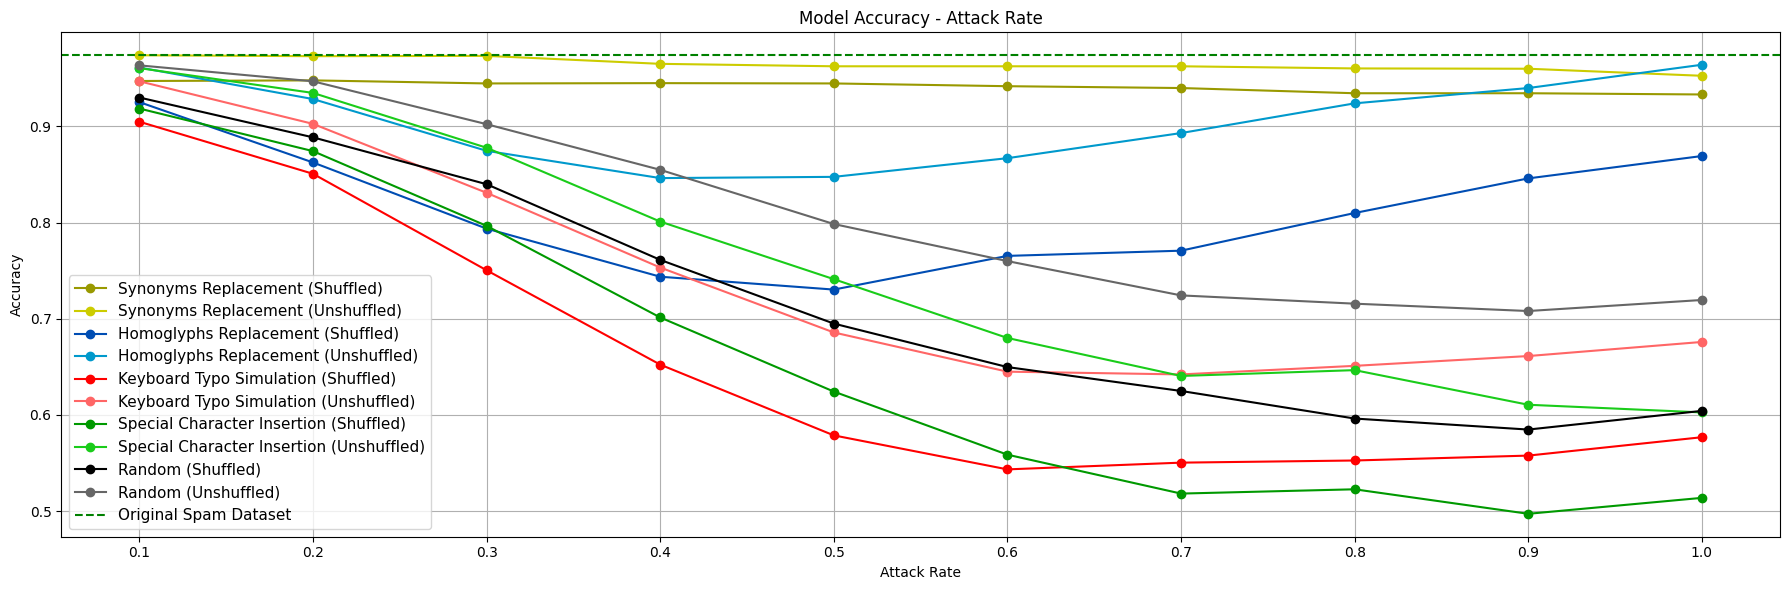

In [82]:
plt.figure(figsize=(18, 6))
plt.title('Model Accuracy - Attack Rate')
plt.xlabel('Attack Rate')
plt.ylabel('Accuracy')
for attack_config, attack_accuracies in performance_accuracy_map.items():
    plt.plot(ATTACK_RATES, attack_accuracies, color=color_map[attack_config], label=f'{attack_config}', marker='o')
plt.xticks(ATTACK_RATES)
plt.axhline(y=0.9745, color='g', linestyle='--', label='Original Spam Dataset')
plt.grid(True)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

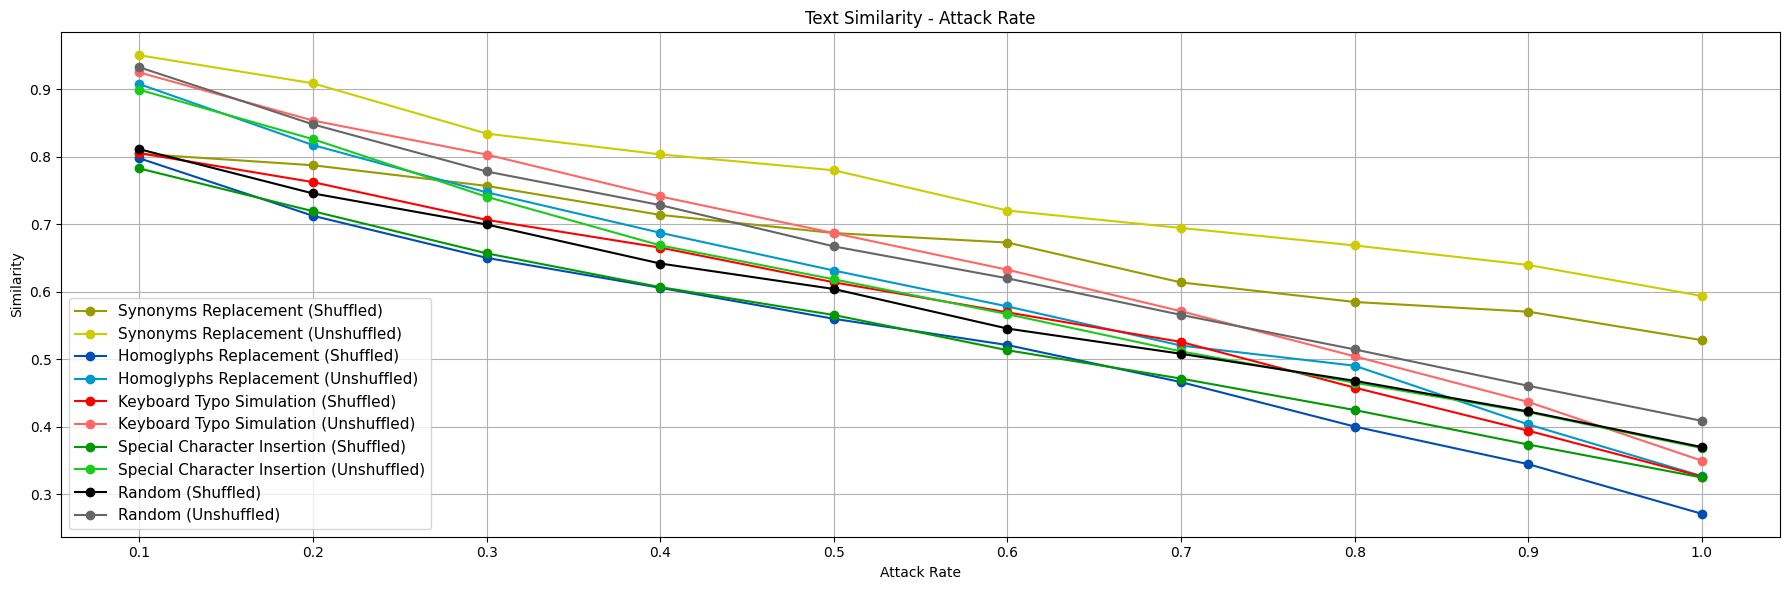

In [83]:
plt.figure(figsize=(18, 6))
plt.title('Text Similarity - Attack Rate')
plt.xlabel('Attack Rate')
plt.ylabel('Similarity')
for attack_config, attack_similarities in performance_similarity_map.items():
    plt.plot(ATTACK_RATES, attack_similarities, color=color_map[attack_config], label=f'{attack_config}', marker='o')
plt.xticks(ATTACK_RATES)
plt.grid(True)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Attack Defending with Adversarial Training

## Util Functions and Adversarial Training Dataset Definition

In [51]:
class AdversarialTrainingDataset(Dataset):
    def __init__(self, data, tokenizer, vocab):
        self.length = len(data)
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.vocab = vocab

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = self.vocab(self.tokenizer(text))
        return torch.tensor(tokens), torch.tensor(label)

def augment_adversarial_train(df_adversarial_train, augment_rate):
    attacker = Attacker()
    df_augmented_adversarial_train = pd.DataFrame(columns=['text', 'label'])
    augmented_train_data = []
    for _, row in df_adversarial_train.iterrows():
        text = row['text']
        label = row['label']
        augmented_train_data.append(pd.Series([text, label], index=df_augmented_adversarial_train.columns))
        if label == 1 and randint(1, 100) <= (augment_rate * 100):
            perturbed_text = attacker.attack(text, choice(ATTACK_RATES), sentence_shuffling=choice([True, False]), attack_type='random')
            augmented_train_data.append(pd.Series([perturbed_text, label], index=df_augmented_adversarial_train.columns))
    df_augmented_adversarial_train = pd.concat([df_augmented_adversarial_train, pd.DataFrame(augmented_train_data)], axis=0, ignore_index=True)
    return df_augmented_adversarial_train

## Dataset Preparation

In [52]:
df_train = pd.read_csv(DATA_PATH_TRAIN)
df_val = pd.read_csv(DATA_PATH_VALIDATION)
df_test = pd.read_csv(DATA_PATH_TEST)
df_test_spams = pd.read_csv(DATA_PATH_TEST_SPAMS)

In [53]:
df_adversarial_train = pd.DataFrame(columns=['text', 'label'])
df_adversarial_val = pd.DataFrame(columns=['text', 'label'])
df_adversarial_test = pd.DataFrame(columns=['text', 'label'])
df_adversarial_spam = pd.DataFrame(columns=['text', 'label'])
adversarial_train_data = []
adversarial_val_data = []
adversarial_test_data = []
adversarial_spam_data = []

for _, row in df_train.iterrows():
    adversarial_train_data.append(pd.Series([row['original_text'], row['label']], index=df_adversarial_train.columns))
for _, row in df_val.iterrows():
    adversarial_val_data.append(pd.Series([row['original_text'], row['label']], index=df_adversarial_val.columns))
for _, row in df_test.iterrows():
    adversarial_test_data.append(pd.Series([row['original_text'], row['label']], index=df_adversarial_test.columns))
for _, row in df_test_spams.iterrows():
    adversarial_spam_data.append(pd.Series([row['original_text'], row['label']], index=df_adversarial_spam.columns))


df_adversarial_train = pd.concat([df_adversarial_train, pd.DataFrame(adversarial_train_data)], axis=0, ignore_index=True)
df_adversarial_train = augment_adversarial_train(df_adversarial_train, AUGMENT_RATE)
df_adversarial_val = pd.concat([df_adversarial_val, pd.DataFrame(adversarial_val_data)], axis=0, ignore_index=True)
df_adversarial_test = pd.concat([df_adversarial_test, pd.DataFrame(adversarial_test_data)], axis=0, ignore_index=True)
df_adversarial_spam = pd.concat([df_adversarial_spam, pd.DataFrame(adversarial_spam_data)], axis=0, ignore_index=True)

df_adversarial_train.to_csv(DATA_PATH_ADVERSARIAL_TRAINING, index=False)
df_adversarial_val.to_csv(DATA_PATH_ADVERSARIAL_VALIDATION, index=False)
df_adversarial_test.to_csv(DATA_PATH_ADVERSARIAL_TEST, index=False)
df_adversarial_spam.to_csv(DATA_PATH_ADVERSARIAL_SPAMS, index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
df_adversarial_train = pd.read_csv(DATA_PATH_ADVERSARIAL_TRAINING)
df_adversarial_val = pd.read_csv(DATA_PATH_ADVERSARIAL_VALIDATION)
df_adversarial_test = pd.read_csv(DATA_PATH_ADVERSARIAL_TEST)
df_adversarial_spam = pd.read_csv(DATA_PATH_ADVERSARIAL_SPAMS)
print(f"Adversarial Train - Spam: {len(df_adversarial_train[df_adversarial_train['label'] == 1])}, Non-Spam: {len(df_adversarial_train[df_adversarial_train['label'] == 0])}, Total: {len(df_adversarial_train)}")

Adversarial Train - Spam: 14174, Non-Spam: 12672, Total: 26846


## Tokenizer and Vocabulary

In [55]:
tokenizer = build_tokenizer()
adversarial_vocab = build_vocab_from_iterator(map(tokenizer, df_adversarial_train["text"]), specials=["<unk>"])
adversarial_vocab.set_default_index(adversarial_vocab["<unk>"])
save_vocab(adversarial_vocab, ADVERSARIAL_VOCAB_PATH)

## Embedding Matrix (Pretrained Word2Vec)

In [56]:
pretrained = load_pretrained_embedding(PRETRAINED_EMBEDDING_PATH)
adversarial_embedding_matrix = build_embedding_matrix(adversarial_vocab, EMBED_DIM, pretrained)
save_embedding_matrix(adversarial_embedding_matrix, ADVERSARIAL_EMBEDDING_MATRIX_PATH)

## Pre-Adversarial-Training - Dataloader

In [62]:
ds_adversarial_train = AdversarialTrainingDataset(df_adversarial_train, tokenizer, adversarial_vocab)
ds_adversarial_val = AdversarialTrainingDataset(df_adversarial_val, tokenizer, adversarial_vocab)
ds_adversarial_test = AdversarialTrainingDataset(df_adversarial_test, tokenizer, adversarial_vocab)
ds_adversarial_spam = AdversarialTrainingDataset(df_adversarial_spam, tokenizer, adversarial_vocab)

dl_adversarial_train = DataLoader(ds_adversarial_train, batch_size=BATCH_SIZE_ADVERSARIAL, shuffle=True, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_adversarial_val = DataLoader(ds_adversarial_val, batch_size=BATCH_SIZE_ADVERSARIAL, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_adversarial_test = DataLoader(ds_adversarial_test, batch_size=BATCH_SIZE_ADVERSARIAL, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)
dl_adversarial_spam = DataLoader(ds_adversarial_spam, batch_size=BATCH_SIZE_ADVERSARIAL, shuffle=False, collate_fn=batch_collate, num_workers=NUM_WORKERS)

## Pre-Adversarial-Training - Model

In [63]:
adversarial_embedding_matrix = load_embedding_matrix(ADVERSARIAL_EMBEDDING_MATRIX_PATH)
adversarial_model = SpamLSTM(adversarial_embedding_matrix, EMBED_DIM, HIDDEN_DIM, OUT_DIM, N_LAYERS, DROPOUT)

## Pre-Adversarial-Training - Optimizer, LR Scheduler and Loss Criterion

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(adversarial_model.parameters(), lr=LR_START, weight_decay=L2_REG_WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE_ADVERSARIAL, verbose=True)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Start Adversarial Training

In [65]:
loss_train, loss_val, acc_val = start_training(adversarial_model, dl_adversarial_train, dl_adversarial_val, optimizer, criterion, lr_scheduler, N_EPOCHS_ADVERSARIAL, device, ADVERSARIAL_LSTM_MODEL_PATH)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 - train loss: 0.2939, val loss: 0.1456, val accuracy: 0.9500
Epoch 2 - train loss: 0.1645, val loss: 0.1870, val accuracy: 0.9296
Epoch 3 - train loss: 0.1228, val loss: 0.0861, val accuracy: 0.9695
Epoch 4 - train loss: 0.0863, val loss: 0.0690, val accuracy: 0.9759
Epoch 5 - train loss: 0.0732, val loss: 0.0667, val accuracy: 0.9767
Epoch 6 - train loss: 0.0591, val loss: 0.0682, val accuracy: 0.9806
Epoch 7 - train loss: 0.0555, val loss: 0.0769, val accuracy: 0.9708
Epoch 8 - train loss: 0.0499, val loss: 0.0640, val accuracy: 0.9778
Epoch 9 - train loss: 0.0442, val loss: 0.0836, val accuracy: 0.9780
Epoch 10 - train loss: 0.0437, val loss: 0.0525, val accuracy: 0.9835


## Evaluate Defending Model Performance Against Original Dataset

In [66]:
adversarial_model = load_model_from_path(ADVERSARIAL_LSTM_MODEL_PATH, ADVERSARIAL_EMBEDDING_MATRIX_PATH)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_avg_loss, test_acc = eval(adversarial_model, dl_adversarial_test, criterion, device)
print(f'test loss: {test_avg_loss:.4f}, test accuracy - {test_acc:.4f}')

test loss: 0.0688, test accuracy - 0.9828


In [67]:
test_spams_avg_loss, test_spams_acc = eval(adversarial_model, dl_adversarial_spam, criterion, device)
print(f'test spams loss: {test_spams_avg_loss:.4f}, test spams accuracy - {test_spams_acc:.4f}')

test spams loss: 0.0885, test spams accuracy - 0.9761


## Evaluate Defending Result

In [70]:
tokenizer = build_tokenizer()
adversarial_vocab = load_vocab(ADVERSARIAL_VOCAB_PATH)
adversarial_model = load_model_from_path(ADVERSARIAL_LSTM_MODEL_PATH, ADVERSARIAL_EMBEDDING_MATRIX_PATH)
run_attack_experiments(adversarial_model, adversarial_vocab, tokenizer, DATA_PATH_TEST_SPAMS_ATTACKED, DATA_PATH_TEST_SPAMS_ATTACKED_ADVERSARIAL_RESULT)
eval_experiments_result(DATA_PATH_TEST_SPAMS_ATTACKED_ADVERSARIAL_RESULT, DATA_PATH_DEFEND_PERFORMANCE_ACC, DATA_PATH_DEFEND_PERFORMANCE_SIM)

Experiment for attack rate 0.1 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.2 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.3 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.4 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.5 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.6 is completed. Result saved to /content/drive/MyDrive/CS5260 Project Group/baseline/data/attacked_spam_emails_adversarial_result.
Experiment for attack rate 0.7 is comple

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Evaluation completed for attack rate 0.1.
Evaluation completed for attack rate 0.2.
Evaluation completed for attack rate 0.3.
Evaluation completed for attack rate 0.4.
Evaluation completed for attack rate 0.5.
Evaluation completed for attack rate 0.6.
Evaluation completed for attack rate 0.7.
Evaluation completed for attack rate 0.8.
Evaluation completed for attack rate 0.9.
Evaluation completed for attack rate 1.0.


In [84]:
defend_performance_accuracy = pd.read_csv(DATA_PATH_DEFEND_PERFORMANCE_ACC)
defend_performance_similarity = pd.read_csv(DATA_PATH_DEFEND_PERFORMANCE_SIM)

In [85]:
defend_performance_accuracy.head(10)

,Attack Rate,Synonyms Replacement (Shuffled),Synonyms Replacement (Unshuffled),Homoglyphs Replacement (Shuffled),Homoglyphs Replacement (Unshuffled),Keyboard Typo Simulation (Shuffled),Keyboard Typo Simulation (Unshuffled),Special Character Insertion (Shuffled),Special Character Insertion (Unshuffled),Random (Shuffled),Random (Unshuffled)
0,0.1,0.978025,0.978025,0.986306,0.986624,0.979299,0.981210,0.981529,0.980573,0.981847,0.982803
1,0.2,0.977707,0.977070,0.986624,0.986943,0.978981,0.984713,0.983439,0.986306,0.987261,0.987261
2,0.3,0.978981,0.979618,0.986624,0.988217,0.982166,0.982803,0.986624,0.985350,0.988535,0.987261
3,0.4,0.981210,0.980255,0.983121,0.983439,0.983439,0.983439,0.984076,0.984076,0.988854,0.986624
4,0.5,0.982803,0.982484,0.981847,0.975478,0.982484,0.979299,0.979936,0.982803,0.984395,0.986306
5,0.6,0.982803,0.984395,0.973885,0.972930,0.975478,0.971656,0.980573,0.982166,0.985669,0.983439
6,0.7,0.987898,0.985350,0.967516,0.971975,0.971019,0.964650,0.982166,0.982484,0.980573,0.981847
7,0.8,0.985032,0.985669,0.963057,0.969108,0.964968,0.963376,0.973248,0.978662,0.981847,0.976433
8,0.9,0.985350,0.985032,0.955096,0.954140,0.958280,0.956369,0.961146,0.962420,0.974522,0.971338
9,1.0,0.986306,0.985669,0.948089,0.948408,0.935350,0.928981,0.948726,0.954140,0.965924,0.964331


In [86]:
defend_performance_similarity.head(10)

,Attack Rate,Synonyms Replacement (Shuffled),Synonyms Replacement (Unshuffled),Homoglyphs Replacement (Shuffled),Homoglyphs Replacement (Unshuffled),Keyboard Typo Simulation (Shuffled),Keyboard Typo Simulation (Unshuffled),Special Character Insertion (Shuffled),Special Character Insertion (Unshuffled),Random (Shuffled),Random (Unshuffled)
0,0.1,0.821010,0.951839,0.809975,0.908756,0.842147,0.935351,0.804241,0.907800,0.840096,0.929137
1,0.2,0.803816,0.918727,0.769930,0.826664,0.785621,0.861210,0.806809,0.849043,0.775598,0.868159
2,0.3,0.781367,0.862820,0.746471,0.763593,0.733790,0.828353,0.692459,0.737455,0.771495,0.800196
3,0.4,0.736585,0.818306,0.612210,0.704923,0.705588,0.737020,0.710435,0.698642,0.704402,0.750559
4,0.5,0.699822,0.790463,0.573649,0.597644,0.658987,0.715394,0.611826,0.606557,0.668169,0.657284
5,0.6,0.664466,0.721947,0.484018,0.543724,0.593576,0.645682,0.555477,0.593498,0.580155,0.652274
6,0.7,0.655930,0.704922,0.437923,0.480339,0.566470,0.587715,0.482486,0.499011,0.571916,0.585244
7,0.8,0.638814,0.692751,0.376562,0.419075,0.522339,0.523009,0.425954,0.446720,0.505099,0.527531
8,0.9,0.608330,0.625990,0.342890,0.370745,0.458826,0.467377,0.378680,0.406660,0.450868,0.461944
9,1.0,0.554825,0.634161,0.266345,0.303606,0.392048,0.399502,0.317438,0.346526,0.397388,0.425713


## Defending Result Visualisation

In [87]:
defend_performance_accuracy_map = {
    'Synonyms Replacement (Shuffled)': defend_performance_accuracy['Synonyms Replacement (Shuffled)'].tolist(),
    'Synonyms Replacement (Unshuffled)': defend_performance_accuracy['Synonyms Replacement (Unshuffled)'].tolist(),
    'Homoglyphs Replacement (Shuffled)': defend_performance_accuracy['Homoglyphs Replacement (Shuffled)'].tolist(),
    'Homoglyphs Replacement (Unshuffled)': defend_performance_accuracy['Homoglyphs Replacement (Unshuffled)'].tolist(),
    'Keyboard Typo Simulation (Shuffled)': defend_performance_accuracy['Keyboard Typo Simulation (Shuffled)'].tolist(),
    'Keyboard Typo Simulation (Unshuffled)': defend_performance_accuracy['Keyboard Typo Simulation (Unshuffled)'].tolist(),
    'Special Character Insertion (Shuffled)': defend_performance_accuracy['Special Character Insertion (Shuffled)'].tolist(),
    'Special Character Insertion (Unshuffled)': defend_performance_accuracy['Special Character Insertion (Unshuffled)'].tolist(),
    'Random (Shuffled)': defend_performance_accuracy['Random (Shuffled)'].tolist(),
    'Random (Unshuffled)': defend_performance_accuracy['Random (Unshuffled)'].tolist()
}

defend_performance_similarity_map = {
    'Synonyms Replacement (Shuffled)': defend_performance_similarity['Synonyms Replacement (Shuffled)'].tolist(),
    'Synonyms Replacement (Unshuffled)': defend_performance_similarity['Synonyms Replacement (Unshuffled)'].tolist(),
    'Homoglyphs Replacement (Shuffled)': defend_performance_similarity['Homoglyphs Replacement (Shuffled)'].tolist(),
    'Homoglyphs Replacement (Unshuffled)': defend_performance_similarity['Homoglyphs Replacement (Unshuffled)'].tolist(),
    'Keyboard Typo Simulation (Shuffled)': defend_performance_similarity['Keyboard Typo Simulation (Shuffled)'].tolist(),
    'Keyboard Typo Simulation (Unshuffled)': defend_performance_similarity['Keyboard Typo Simulation (Unshuffled)'].tolist(),
    'Special Character Insertion (Shuffled)': defend_performance_similarity['Special Character Insertion (Shuffled)'].tolist(),
    'Special Character Insertion (Unshuffled)': defend_performance_similarity['Special Character Insertion (Unshuffled)'].tolist(),
    'Random (Shuffled)': defend_performance_similarity['Random (Shuffled)'].tolist(),
    'Random (Unshuffled)': defend_performance_similarity['Random (Unshuffled)'].tolist()
}

colors = {
    'YellowDark': (0.6, 0.6, 0.0),
    'YellowLight': (0.8, 0.8, 0.0),
    'BlueDark': (0.0, 0.3, 0.7),
    'BlueLight': (0.0, 0.6, 0.8),
    'RedDark': (1.0, 0.0, 0.0),
    'RedLight': (1.0, 0.4, 0.4),
    'GreenDark': (0.0, 0.6, 0.0),
    'GreenLight': (0.1, 0.8, 0.1),
    'BlackDark': (0.0, 0.0, 0.0),
    'BlackLight': (0.4, 0.4, 0.4)
}

color_map = {
    'Synonyms Replacement (Shuffled)': colors['YellowDark'],
    'Synonyms Replacement (Unshuffled)': colors['YellowLight'],
    'Homoglyphs Replacement (Shuffled)': colors['BlueDark'],
    'Homoglyphs Replacement (Unshuffled)': colors['BlueLight'],
    'Keyboard Typo Simulation (Shuffled)': colors['RedDark'],
    'Keyboard Typo Simulation (Unshuffled)': colors['RedLight'],
    'Special Character Insertion (Shuffled)': colors['GreenDark'],
    'Special Character Insertion (Unshuffled)': colors['GreenLight'],
    'Random (Shuffled)': colors['BlackDark'],
    'Random (Unshuffled)': colors['BlackLight'],
}

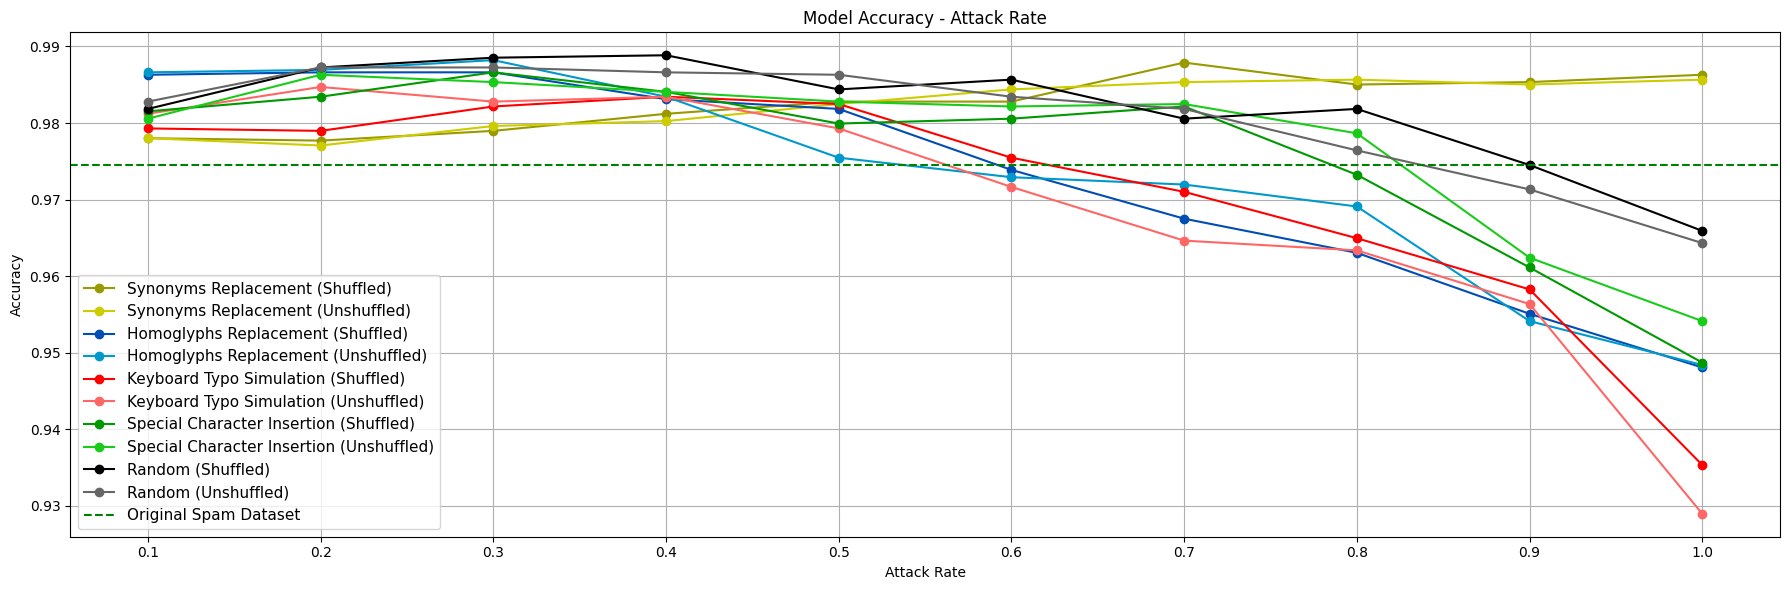

In [88]:
plt.figure(figsize=(18, 6))
plt.title('Model Accuracy - Attack Rate')
plt.xlabel('Attack Rate')
plt.ylabel('Accuracy')
for attack_config, attack_accuracies in defend_performance_accuracy_map.items():
    plt.plot(ATTACK_RATES, attack_accuracies, color=color_map[attack_config], label=f'{attack_config}', marker='o')
plt.xticks(ATTACK_RATES)
plt.axhline(y=0.9745, color='g', linestyle='--', label='Original Spam Dataset')
plt.grid(True)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

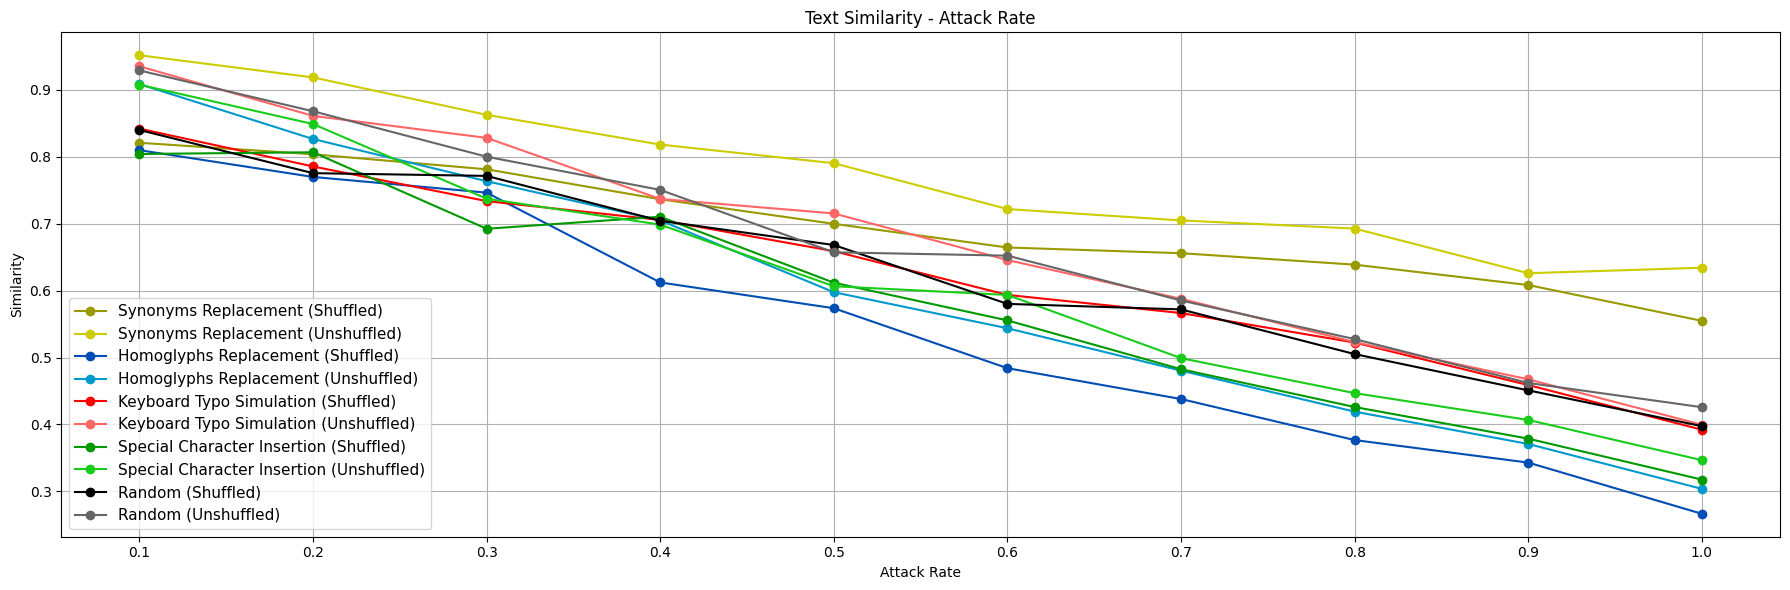

In [89]:
plt.figure(figsize=(18, 6))
plt.title('Text Similarity - Attack Rate')
plt.xlabel('Attack Rate')
plt.ylabel('Similarity')
for attack_config, attack_similarities in defend_performance_similarity_map.items():
    plt.plot(ATTACK_RATES, attack_similarities, color=color_map[attack_config], label=f'{attack_config}', marker='o')
plt.xticks(ATTACK_RATES)
plt.grid(True)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()